In [46]:
include("../scripts/mcl.jl")

draw (generic function with 7 methods)

In [2]:
function sigma_ellipse(p, cov, n)
    eig_vals= eigvals(cov)
    eig_vec = eigvecs(cov)
    ang = atan(eig_vec[1,:][2], eig_vec[1,:][1])/pi * 180
    return patches.Ellipse(p, width=2*n*sqrt(eig_vals[1]), 
        height=2*n*sqrt(eig_vals[2]), angle=ang, fill=false, color="blue", alpha=0.5)
end

sigma_ellipse (generic function with 1 method)

In [4]:
function matM(nu, omega, time, stds)
    return Diagonal([stds["nn"]^2*abs(nu)/time + stds["no"]^2*abs(omega)/time,
            stds["on"]^2*abs(nu)/time + stds["oo"]^2*abs(omega)/time])
end

matM (generic function with 1 method)

In [86]:
function matA(nu, omega, time, theta)
    st, ct = sin(theta), cos(theta)
    stw, ctw = sin(theta+omega*time), cos(theta+omega*time)
    return [(stw-st)/omega -nu/(omega^2)*(stw-st)+nu/omega*time*ctw;
                 (-ctw+ct)/omega -nu/(omega^2)*(-ctw+ct)+nu/omega*time*stw;
                 0.0 time]
end

matA (generic function with 1 method)

In [97]:
function matF(nu, omega, time, theta)
    F = [1.0 0.0 0.0;0.0 1.0 0.0; 0.0 0.0 1.0]
    F[1, 3] = nu / omega * (cos(theta + omega * time) - cos(theta))
    F[2, 3] = nu / omega * (sin(theta + omega * time) - sin(theta))
    return F
end

matF (generic function with 1 method)

In [98]:
mutable struct KalmanFilter
    belief
    pose
    motion_noise_stds
end

In [107]:
function KalmanFilter_(envmap, init_pose, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2))
    self = KalmanFilter(ntuple(x->nothing, fieldcount(KalmanFilter))...)
    self.belief = MvNormal([0.0,0.0, 0.0], Diagonal([1e-10, 1e-10, 1e-10]))
    self.pose = self.belief.μ
    self.motion_noise_stds = motion_noise_stds
    return self
end

KalmanFilter_ (generic function with 2 methods)

In [108]:
function motion_update(self::KalmanFilter, nu, omega, time)
    if abs(omega) < 1e-5
        omega = 1e-5
    end
    
    M = matM(nu, omega, time, self.motion_noise_stds)
    A = matA(nu, omega, time, self.belief.μ[3])
    F = matF(nu, omega, time, self.belief.μ[3])
    n_cov = F*self.belief.Σ*F' + A*M*A'
    n_mean = state_transition(IdealRobot(), nu, omega, time, self.belief.μ)
#     print(n_cov)
    self.belief = MvNormal(n_mean, Symmetric(n_cov))
    self.pose = self.belief.μ
end

motion_update (generic function with 3 methods)

In [109]:
function observation_update(self::KalmanFilter, observation)
end

observation_update (generic function with 3 methods)

In [110]:
function draw(self::KalmanFilter, ax, elems)
    e = sigma_ellipse(self.belief.μ[1:2], self.belief.Σ[1:2, 1:2], 3)
    elems = vcat(elems, [ax.add_patch(e)])
    
    x,y,c = self.belief.μ
    sigma3 = sqrt(self.belief.Σ[3,3])*3
    xs = [x + cos(c-sigma3), x, x + cos(c+sigma3)]
    ys = [y + sin(c-sigma3), y, y + sin(c+sigma3)]
    elems = vcat(elems, ax.plot(xs, ys, color="blue", alpha=0.5))
end

draw (generic function with 8 methods)

In [111]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    kf = KalmanFilter_(m, initial_pose)
    circling = EstimationAgent_(time_interval, 0.2, 10.0/180*pi, kf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=circling, color="red")
    append(world, r)
    
    kf2 = KalmanFilter_(m, initial_pose)
    linear = EstimationAgent_(time_interval, 0.1, 0.0, kf2)
    r2 = Robot_(initial_pose, sensor=Camera_(m), agent=linear, color="red")
    append(world, r2)
    
    kf3 = KalmanFilter_(m, initial_pose)
    right = EstimationAgent_(time_interval, 0.1, -3.0/180*pi, kf3)
    r3 = Robot_(initial_pose, sensor=Camera_(m), agent=right, color="red")
    append(world, r3)

    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQACC25tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHMdliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+ir6AAi/ximafLajEKNv7Lw0M8qwpqegzxubJ5ksq1o1ak8MWo5ExiAutL+4sa6ducW9LnJ/HlRhQS/uDuAYZOie2h0NC0fSCAkvoQWQN2jx/piWEhGDjKonuFFNQNTfjAsPC4vY5oRadFNo9n0iTGUw7IJjI2GasaLU9Iv4b+aS7XCO/w2axSSs4uW0UobWYPDfUuyT8lg4T1MK+fgaeXWTf8GHSxwkrUXyj+yRF2f2QFQDWTDfq7YV7/epaHv3DEhORf9HH7LJLe9QlHpMS1+/2ZqQuN8k6p/EsVfDEjgEzc0uYIh/hqGcMAxZzX3aCz/YkwqR5xYfcRpSJ6x9BYf/Z8aLgs1YYDW80B7N3+dhH1ORoXgaO9awq3/W56t6kpUyPtbcsnxlS5nt1Y5IhhsmYxxF3Zu+xOanQ+G5biUrIuFjJpQu3M4Qp5hmmGwFuOvi5GUHs43gBKigCZ/i/J75AObuDZovIUJ7g5kBG5V9l3ffXf6iQX8mYq0+3u/SjL3oAFUcKx+iR0A65toxGZJPeV0S3f2THf5bXKCiw6S8+Ju8Xg2BMUVtUPn3rjdFipMrFw0x8ZwAyVnW46SrCL22BtHnZnoQgQAt7FwXJcAfs3T4YobGEBf9Dwco7tsa86/8j8qPVmk/3kokKQPo/13wkQqunr+48XBAz/uxpVPA+7pedwZI4BRsaLytTV9fSf0mL5H7PcdvKK8i7L3nU3zRDBe2O1VPI5jvayblmhOk/dkdNlqVH5Ob0kEjTEigvW+EOCRnH/dWABMp/qZLqAFq23ypUtSxGZWRX/ZLM9mmH0YIKlSVcTsbHeg8bcwPQKL4FplsL1ghBkYGtd8PW4nPFZ1EYpyABFl+uivhR7S4NdOVzJVvUB+fJO0h3GYgr1Q7iC1kWVY8g/XqxH3aFihcmVIlQRuhVFsIT315ZKGW3aXUpdRnOPWlBIuXNDC6q+D8m7AYKT769VZqYcyY6ACWRtE2r/9xAIqxzHV2Pyk0fX93HhLwQZy/IqW4i4vKAFTwyPosfUEh/eaxENHrnf4/P7XPpMhDNAEGpEqYlx2aabeINojVrOriI2thELI5B79DNS/pRPZfMFNw0phs8I2M7zZn0thZZrRZXDbG+F5hCfMPjSyR8CAz1bLfQQoSG0KGt5VjIxwq0VasoVxNj2d9TQzYDLDAC2LTKE+5w/3VpCd/69NS7E93LzzEeRzOAI4UkDerUQLnSJ5jVFpffEJC2LaV1/mMTi0GQAkhlsjDgn90eM+EAs//Ahzmp7h3yG/PdBLBmXeH5nEF2wQYbzC0JJmfUUkuzVK24A6UcTjgMdQfIb+fhe+k0fIDrj9kDPOeUYTJovrGbN5im9KFZTjXlQSsCl7LZMjnq0GICZ4wBNXteOS+l/pqGqGXpiRmk7zbg9qpXQO8eXK/lxa01paI2W3yMT3WywU5jqUr4n5cLnzVSK0gCkqrhMLIoXotB2W8OKLyv6mEx1tScNdkBG8r8oWiRI1fJgNnM/fQJQqEq0IRds++Riknn8d2Vie9Gl5X3k33QTZBudOq6jFV4poDdmXEs8zamyZc5fr7suNDxuy5pBqsmLeisN/fIz4uyLnQFrY61VVu9FvynDOT08y/3z2GCBFLm21NRk6kdW+HJFbEzNotgVDpvsr5SDfvdrIVtNk0qbaR2/7r3KA8+Cq/ZCBrNlGKlW7I0LflwanjmAVzIoTcdRumkkg0gsBkjOSjIN1IbNUlypdTTCktGk/N1/gU62Alllm95yzBSNniO/WX3lIzggymKWys8QSZDlF/7Ojo33FJ+G5a1H812OafOk59CRCMAK94tc1dWgfUHL+fdtLjgHVn21flXpYnYdmkNK/2gox1QJusuMznqDmOVujmqdo4KGIv5nGDXmNshZGr5+i/q/4HjNi4eZbkG8V077oJyTjrP/6T47wgeYuj4vYycVrAlCHyhjTG/3FS7vyBV4bi/wE3UF+lCXP09pGpbUEuB5YZ1XlIVKuiN83MTa6jij+VvLvyvg3yFqQcc8

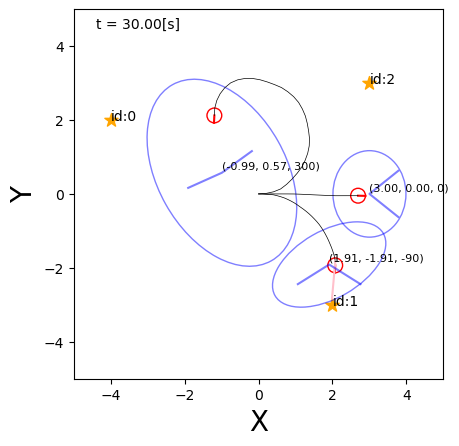

In [112]:
trial()